## MTH6412B - Projet Phase 3
#### Victor Darleguy - Nathan Allaire

In [2]:
include("../Phase 1/node.jl")
include("../Phase 1/edge.jl")
include("../Phase 1/graph.jl")
include("../Phase 1/read_stsp.jl")

plot_graph

In [3]:
include("../Phase 1/main.jl")

build_graph

In [5]:
include("../Phase 2/utils.jl")
include("../Phase 2/PriorityQueue.jl")
include("utils.jl")

tracer_graphe (generic function with 1 method)

In [6]:
import Pkg; Pkg.add("BenchmarkTools")

   Resolving package versions...


  No Changes to `C:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Project.toml`
  No Changes to `C:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Manifest.toml`


Precompiling project...


  ✓ BenchmarkTools
  1 dependency successfully precompiled in 1 seconds. 10 already precompiled.


Les fonctions suivantes sont utilisées pour tracer les graphiques associés à nos résultats

In [7]:
"""
    calculate_tour_weight(tour, graph::ExtendedGraph) -> Float64

Calcule le poids total d'un circuit dans un graphe étendu.

# Arguments
- `tour` : Un vecteur des noms des nœuds représentant le circuit à évaluer.
- `graph::ExtendedGraph` : Une instance de la structure `ExtendedGraph` qui contient un ensemble d'arêtes avec des poids associés.

# Retourne
- `total_weight::Float64` : Le poids total du circuit donné.

# Exemple
```julia
tour = ["A", "B", "C", "A"]  # Un exemple de circuit
graph = ExtendedGraph(...)    # Une instance de graphe étendu
total_weight = calculate_tour_weight(tour, graph)
"""

function calculate_tour_weight(tour, graph::ExtendedGraph)
    edge_weights = Dict()
    for edge in graph.edges
        edge_weights[(edge.start_node.name, edge.end_node.name)] = edge.weight
        # Si le graphe est non orienté et que le poids est le même dans les deux sens:
        edge_weights[(edge.end_node.name, edge.start_node.name)] = edge.weight
    end
  
    total_weight = 0.0
    for i in 1:length(tour)-1
        start_node = tour[i]
        end_node = tour[i+1]
        # Vérifier si l'arête dans le sens inverse est également dans le dictionnaire
        weight = get(edge_weights, (start_node, end_node), get(edge_weights, (end_node, start_node), NaN))
        if isnan(weight)
            error("Le poids de l'arête entre $start_node et $end_node est introuvable.")
        end
        total_weight += weight
    end
    return total_weight
  end

calculate_tour_weight (generic function with 1 method)

In [8]:
"""
tracer_graphe(tour, graph::ExtendedGraph; offset_x=0, offset_y=0, poids_opti=1, placement_erreur=:topleft)

Trace un graphe étendu en visualisant le circuit donné.

# Arguments
- `tour` : Un vecteur des noms des nœuds représentant le circuit à tracer.
- `graph::ExtendedGraph` : Une instance de la structure ExtendedGraph qui contient un ensemble de nœuds avec des données de position.

# Options
- `offset_x` : Le décalage horizontal à appliquer aux annotations des nœuds (par défaut 0).
- `offset_y` : Le décalage vertical à appliquer aux annotations des nœuds (par défaut 0).
- `poids_opti` : Le poids optimal pour le calcul de l'erreur relative (par défaut 1).
- `placement_erreur` : La position de l'annotation de l'erreur relative (par défaut :topleft).

# Exemple
``` julia
tour = ["A", "B", "C", "A"]      # Un exemple de circuit
graph = ExtendedGraph(...)        # Une instance de graphe étendu
tracer_graphe(tour, graph)        # Tracé du circuit sur le graphe
"""
  function tracer_graphe(tour, graph::ExtendedGraph; offset_x=0, offset_y = 0, poids_opti = 1, placement_erreur = :topleft)
    dict_nodes_data = Dict(node.name => node.data for node in graph.nodes)
    xs = []
    ys = []
    
    weight_tour = calculate_tour_weight(tour, graph)
  
    for node in tour
      push!(xs, dict_nodes_data[node][1])
      push!(ys, dict_nodes_data[node][2])
    end
  
    plot(legend = false, title=graph.name, left_margin = 5Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm, bottom_margin = 5Plots.mm)
    for i in 1:length(xs)-1
      plot!([xs[i], xs[i+1]], [ys[i], ys[i+1]], arrow=true)
    end
    
    scatter!(xs, ys, label="Nodes", color="blue")
  
    for (i, (x, y)) in enumerate(zip(xs, ys))
      annotate!(x + offset_x, y + offset_y, text(tour[i], 8))  
    end
    rel = 100*round(weight_tour/poids_opti - 1, digits=2)
    annotate!(placement_erreur, text("erreur relative : $(rel)%", 9))
  
    display(plot!())
  end

tracer_graphe

## 1. Implémentation de l’algorithme de Rosenkrantz, Stearns et Lewis

a. Fonction de recherche des noeuds voisins d'un noeud

In [9]:
"""
    neighbours(graph::ExtendedGraph, node::Node) -> Array

Retourne un tableau des arêtes voisines d'un nœud spécifique dans un graphe.

# Arguments
- `graph::ExtendedGraph`: Le graphe dans lequel rechercher les voisins. `ExtendedGraph` doit être
  une structure définie par l'utilisateur ou une partie d'une bibliothèque graphique, contenant
  un champ `edges` représentant les arêtes du graphe.
- `node::Node`: Le nœud pour lequel les arêtes voisines sont recherchées. `Node` est une structure
  définissant un nœud dans le graphe.

# Exemple
g = ExtendedGraph(...)  # Création ou initialisation d'un ExtendedGraph
n = Node(...)  # Création ou sélection d'un Node
voisins = neighbours(g, n)

Chaque arête dans graph.edges est vérifiée pour déterminer si elle est connectée au node donné.
"""

function neighbours(graph::ExtendedGraph, node::Node)
# Initialisation d'un tableau vide pour stocker les arêtes voisines du nœud
    edges_voisins = Edge[]
    # Parcours de toutes les arêtes dans le graphe
    for e in graph.edges
        # Vérification si l'arête courante est connectée au nœud spécifié
        if node == e.start_node || node == e.end_node
            # Ajout de l'arête au tableau si elle est connectée au nœud
            push!(edges_voisins, e)
        end
    end
    # Retour du tableau des arêtes voisines
    return edges_voisins
end

neighbours (generic function with 1 method)

b. Implementation récursive de l’algorithme de Rosenkrantz, Stearns et Lewis

In [10]:
"""
    RSL!(graph::ExtendedGraph, racine::Node, root_node::Node, visited::Set{Node{T}}=Set{Node{T}}(), path::Vector{Node{T}}=Vector{Node{T}}()) where T

Effectue une recherche récursive à partir d'une racine donnée dans un graphe étendu, enregistrant le chemin parcouru.

Cette fonction modifie les ensembles `visited` et `path` en place, en ajoutant respectivement les nœuds visités et le chemin parcouru.

# Arguments
- `graph::ExtendedGraph` : Le graphe dans lequel la recherche est effectuée.
- `racine::Node` : Le nœud actuel à partir duquel la recherche continue.
- `root_node::Node` : Le nœud racine à partir duquel la recherche a commencé.
- `visited::Set{Node{T}}` : Un ensemble des nœuds déjà visités.
- `path::Vector{Node{T}}` : Un vecteur représentant le chemin parcouru.

# Valeur de retour
- `path::Vector{Node{T}}` : Le chemin parcouru mis à jour.

# Exemple
```julia
g = ExtendedGraph(...)  # Initialiser un ExtendedGraph
root = Node(...)        # Définir un nœud racine
visited = Set{Node{T}}()
path = Vector{Node{T}}()
result_path = RSL!(g, root, root, visited, path)
"""

function RSL!(graph::ExtendedGraph, racine::Node, root_node::Node, visited::Set{Node{T}}=Set{Node{T}}(), path::Vector{String}=Vector{String}()) where T
    # Marquer le nœud racine comme visité
    push!(visited, racine)
    # Ajouter le nom du nœud racine au chemin
    push!(path, racine.name)  
    # Obtenir les arêtes voisines du nœud racine
    edges = neighbours(graph, racine)
    
    # Itérer sur chaque arête voisine
    for e in edges
        # Déterminer le prochain nœud à visiter
        next_node = e.start_node == racine ? e.end_node : e.start_node
        # Si le prochain nœud n'a pas été visité
        if !(next_node in visited)
            # Définir le parent du prochain nœud
            next_node.parent = racine
            # Continuer la recherche récursive à partir du prochain nœud
            RSL!(graph, next_node, root_node, visited, path)  
        end
    end

    # Vérifier si tous les nœuds ont été visités
    all_visited = all(node -> node in visited, nodes(graph))

    # Si tous les nœuds ont été visités et que le dernier nœud n'est pas le nœud racine
    if all_visited && path[end] != root_node.name
        # Ajouter le nom du nœud racine au chemin
        push!(path, root_node.name)
    end

    # Retourner le chemin parcouru
    return path
end

RSL! (generic function with 5 methods)

In [11]:
"""
    RSL(tsp::ExtendedGraph; kruskal_or_prim=Kruskal)

Effectue une recherche en profondeur récursive dans un arbre couvrant minimum (MST) d'un graphe.
Le graphe MST est généré en utilisant l'algorithme de Kruskal ou de Prim selon le paramètre.

# Arguments
- `tsp::ExtendedGraph` : Une instance de la structure de données `ExtendedGraph`, qui représente le graphe complet à partir duquel l'MST est construit.
- `kruskal_or_prim` : La fonction utilisée pour générer l'MST, avec Kruskal comme valeur par défaut.

# Valeur de retour
- Un vecteur représentant le chemin parcouru en effectuant la recherche en profondeur à partir du nœud racine dans l'MST.

# Exemple
```julia
tsp = ExtendedGraph(...)  # Initialiser un ExtendedGraph
path = RSL(tsp)  # Appeler la fonction RSL pour effectuer la recherche dans l'MST
"""

function RSL(tsp::ExtendedGraph; kruskal_or_prim=Kruskal)
    # Copier profondément le graphe pour ne pas modifier le graphe original pendant la création de l'MST
    graph = deepcopy(tsp)
    # Générer l'arbre couvrant minimum en utilisant l'algorithme spécifié (Kruskal ou Prim)
    mst = kruskal_or_prim(graph)
    # Sélectionner le deuxième nœud de l'MST comme nœud racine pour la recherche
    root_node = mst.nodes[2]
    # Initialiser un ensemble vide pour garder une trace des nœuds visités
    visited_nodes = Set{Node}()
    # Appeler la fonction RSL! avec l'MST, le nœud racine, et l'ensemble des nœuds visités
    return RSL!(mst, root_node, root_node, visited_nodes)
  end  

RSL (generic function with 1 method)

c. Exemple trivial d'utilisation

In [12]:
using Plots

function create_graph()
    # 3 : exemple du cours
    a, b, c, d, e, f, g, h, i = Node("a", [0., 1.]), Node("b", [1., 2.]), Node("c", [2., 2.]), Node("d", [3., 2.]), Node("e", [4., 1.]), Node("f", [3., 0.]), Node("g", [2., 0.]), Node("h", [1., 0.]), Node("i", [1.5, 1.])
    e1 = Edge(a, b, 4.)
    e2 = Edge(b, c, 8.)
    e3 = Edge(c, d, 7.)
    e4 = Edge(d, e, 9.)
    e5 = Edge(e, f, 10.)
    e6 = Edge(d, f, 14.)
    e7 = Edge(f, c, 4.)
    e8 = Edge(f, g, 2.)
    e9 = Edge(g, i, 6.)
    e10 = Edge(g, h, 1.)
    e11 = Edge(a, h, 8.)
    e12 = Edge(h, i, 7.)
    e13 = Edge(i, c, 2.)
    e14 = Edge(b, h, 11.)
    G_cours = ExtendedGraph("graphe du cours", [a, b, c, d, e, f, g, h, i], [e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14])
    
    
    graph_cours_kruskal = Kruskal(G_cours)
    graph_cours_prim = Prim(G_cours, st_node = a)
  
    return graph_cours_kruskal, graph_cours_prim, G_cours
  end
  kruskal, prim, cours = create_graph()

(ExtendedGraph{Vector{Float64}, Float64}("res Kruskal", Node{Vector{Float64}}[Node{Vector{Float64}}("a", [0.0, 1.0], nothing, 0), Node{Vector{Float64}}("b", [1.0, 2.0], nothing, 0), Node{Vector{Float64}}("c", [2.0, 2.0], nothing, 0), Node{Vector{Float64}}("d", [3.0, 2.0], nothing, 0), Node{Vector{Float64}}("e", [4.0, 1.0], nothing, 0), Node{Vector{Float64}}("f", [3.0, 0.0], nothing, 0), Node{Vector{Float64}}("g", [2.0, 0.0], nothing, 0), Node{Vector{Float64}}("h", [1.0, 0.0], nothing, 0), Node{Vector{Float64}}("i", [1.5, 1.0], nothing, 0)], Edge{Vector{Float64}, Float64}[Edge{Vector{Float64}, Float64}(Node{Vector{Float64}}("g", [2.0, 0.0], nothing, 0), Node{Vector{Float64}}("h", [1.0, 0.0], nothing, 0), 1.0), Edge{Vector{Float64}, Float64}(Node{Vector{Float64}}("f", [3.0, 0.0], nothing, 0), Node{Vector{Float64}}("g", [2.0, 0.0], nothing, 0), 2.0), Edge{Vector{Float64}, Float64}(Node{Vector{Float64}}("i", [1.5, 1.0], nothing, 0), Node{Vector{Float64}}("c", [2.0, 2.0], nothing, 0), 2.0),

In [13]:
# Pour cet exemple, nous utilisons l'algorithme de Kruskal sur le graphe du cours 
tour = RSL(cours)

9-element Vector{String}:
 "b"
 "a"
 "c"
 "i"
 "f"
 "g"
 "h"
 "d"
 "e"

In [14]:
using BenchmarkTools
_, _, g = create_graph()
benchmark_result = @benchmark RSL($g)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  30.800 μs …  3.672 ms  ┊ GC (min … max): 0.00% … 97.83%
 Time  (median):     35.600 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   37.143 μs ± 50.857 μs  ┊ GC (mean ± σ):  1.91% ±  1.38%

           ▃▇█▆▂                                               
  ▁▁▂▂▂▂▃▄██████▆▆▅▃▃▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  30.8 μs         Histogram: frequency by time          54 μs <

 Memory estimate: 9.63 KiB, allocs estimate: 153.

In [15]:
println(benchmark_result)

Trial(30.800 μs)


d. Essayons maintenant la fonction 'RSL!' sur un fichier tsp

In [16]:
# Les plots des tsp des villes : 
g1 = build_graph("../Phase 1/instances/stsp/bays29.tsp", "bays29")
g2 = build_graph("../Phase 1/instances/stsp/dantzig42.tsp", "dantzig42")
g3 = build_graph("../Phase 1/instances/stsp/gr120.tsp", "gr120")

ExtendedGraph{Vector{Float64}, Float64}("gr120", Node{Vector{Float64}}[Node{Vector{Float64}}("1", [8.0, 124.0], nothing, 0), Node{Vector{Float64}}("2", [125.0, 80.0], nothing, 0), Node{Vector{Float64}}("3", [97.0, 74.0], nothing, 0), Node{Vector{Float64}}("4", [69.0, 96.0], nothing, 0), Node{Vector{Float64}}("5", [106.0, 46.0], nothing, 0), Node{Vector{Float64}}("6", [49.0, 57.0], nothing, 0), Node{Vector{Float64}}("7", [80.0, 125.0], nothing, 0), Node{Vector{Float64}}("8", [42.0, 93.0], nothing, 0), Node{Vector{Float64}}("9", [104.0, 94.0], nothing, 0), Node{Vector{Float64}}("10", [35.0, 17.0], nothing, 0)  …  Node{Vector{Float64}}("111", [16.0, 89.0], nothing, 0), Node{Vector{Float64}}("112", [66.0, 50.0], nothing, 0), Node{Vector{Float64}}("113", [98.0, 194.0], nothing, 0), Node{Vector{Float64}}("114", [87.0, 45.0], nothing, 0), Node{Vector{Float64}}("115", [132.0, 87.0], nothing, 0), Node{Vector{Float64}}("116", [52.0, 99.0], nothing, 0), Node{Vector{Float64}}("117", [50.0, 212.0],

In [17]:
rg1 = RSL(g1) 
rg2 = RSL(g2)
rg3 = RSL(g3)

120-element Vector{String}:
 "2"
 "115"
 "11"
 "51"
 "9"
 "23"
 "103"
 "119"
 "82"
 "3"
 ⋮
 "15"
 "59"
 "120"
 "76"
 "1"
 "4"
 "40"
 "72"
 "105"

e. Traçons les trounées obtenues

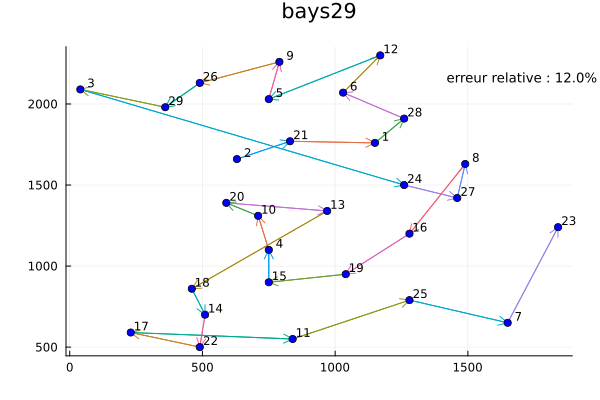

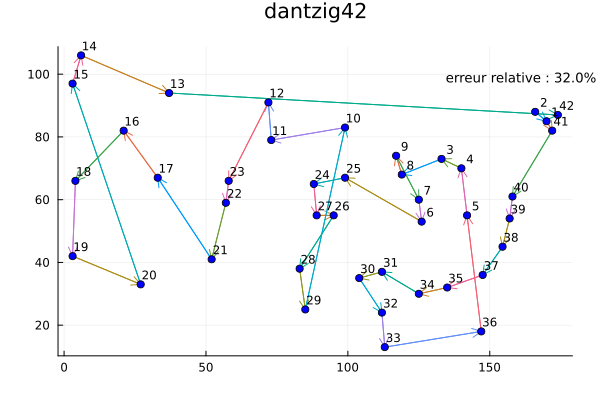

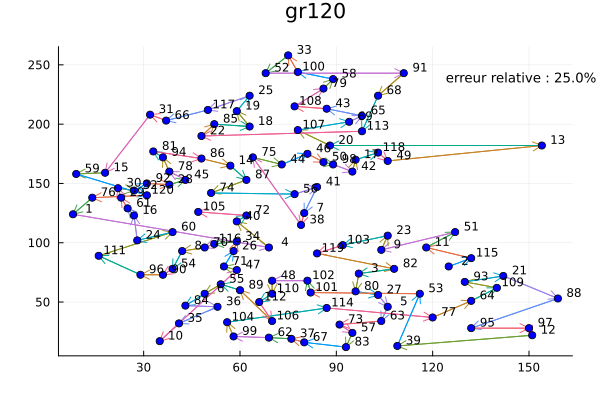

In [18]:
tracer_graphe(rg1, g1, offset_x = 40, offset_y = 40, poids_opti=2020, placement_erreur=:topright)
tracer_graphe(rg2, g2, offset_x = 3, offset_y=3, poids_opti=699, placement_erreur=:topright)
tracer_graphe(rg3, g3, offset_x = 5, offset_y=5, poids_opti=6942, placement_erreur=:topright)

In [20]:
using 
g1 = build_graph("../Phase 1/instances/stsp/bays29.tsp", "bays29")
g2 = build_graph("../Phase 1/instances/stsp/dantzig42.tsp", "dantzig42")
g3 = build_graph("../Phase 1/instances/stsp/gr120.tsp", "gr120")
benchmark_result_g1 = @benchmark RSL($g1)
benchmark_result_g2 = @benchmark RSL($g2)
benchmark_result_g3 = @benchmark RSL($g3)

BenchmarkTools.Trial: 405 samples with 1 evaluation.
 Range (min … max):  10.965 ms … 22.988 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.122 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.326 ms ±  1.045 ms  ┊ GC (mean ± σ):  0.43% ± 2.45%

      ▁▁▃██▆██▆▇▆▄ ▂                                           
  ▂▃▃▅████████████▆█▆█▇▅▇▃▃▅▃▃▂▃▂▃▂▂▁▁▁▁▂▁▁▁▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▂ ▄
  11 ms           Histogram: frequency by time        16.6 ms <

 Memory estimate: 951.09 KiB, allocs estimate: 15977.

In [21]:
benchmark_result_g2

BenchmarkTools.Trial: 3163 samples with 1 evaluation.
 Range (min … max):  1.214 ms …   6.836 ms  ┊ GC (min … max): 0.00% … 60.05%
 Time  (median):     1.365 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.575 ms ± 495.003 μs  ┊ GC (mean ± σ):  0.87% ±  4.22%

   ▂█▇▄                                                        
  ▂█████▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.21 ms         Histogram: frequency by time        2.99 ms <

 Memory estimate: 182.95 KiB, allocs estimate: 2328.

In [23]:
benchmark_result_g1

BenchmarkTools.Trial: 7198 samples with 1 evaluation.
 Range (min … max):  585.000 μs …   5.926 ms  ┊ GC (min … max): 0.00% … 86.95%
 Time  (median):     674.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   692.129 μs ± 205.525 μs  ┊ GC (mean ± σ):  1.56% ±  4.54%

               ▁▁▁▃█▇▄▃▄▂  ▁                                     
  ▂▂▂▂▃▃▃▃▄▄▅▄▇██████████████▇▅▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂ ▄
  585 μs           Histogram: frequency by time          858 μs <

 Memory estimate: 139.58 KiB, allocs estimate: 1241.

## 2. Implémentation l’algorithme de montée de Held et Karp (HK)

a. Définissons une fonction permettant de supprimer un nœud et ses arêtes incidentes d'un graphe

In [24]:
using LinearAlgebra
using Printf

"""
    remove_node_and_edges(graph::ExtendedGraph, special_node::Node) :: ExtendedGraph

Enlève un nœud spécifique et toutes les arêtes incidentes à ce nœud d'un graphe étendu, et retourne le nouveau graphe.

# Arguments
- `graph::ExtendedGraph` : Le graphe original à partir duquel le nœud et les arêtes seront enlevés.
- `special_node::Node` : Le nœud à enlever du graphe.

# Retour
- `ExtendedGraph` : Une nouvelle instance de `ExtendedGraph` qui est une copie du graphe original avec le nœud spécifique et toutes ses arêtes incidentes enlevés.

# Exemples
```julia
graph = ExtendedGraph(...)  # Un graphe étendu original
special_node = Node(...)    # Le nœud à enlever
new_graph = remove_node_and_edges(graph, special_node)
Cette fonction est utile pour manipuler des graphes lorsque vous avez besoin d'évaluer les conséquences de la suppression d'un nœud et de ses arêtes connectées, par exemple, dans des scénarios de résilience de réseau ou d'optimisation de graphe.
"""
function remove_node_and_edges(graph::ExtendedGraph, special_node::Node) :: ExtendedGraph
  # Copie le graphe
  new_graph = deepcopy(graph)

  # Supprime les arêtes incidentes au nœud spécial
  new_graph.edges = filter(e -> e.start_node != special_node && e.end_node != special_node, new_graph.edges)

  # Supprime également le nœud spécial
  new_graph.nodes = filter(n -> n != special_node, new_graph.nodes)

  return new_graph
end

remove_node_and_edges

b. Fonction permettant de trouver un 1-arbre minimum à partir d'un nœud spécifié

In [25]:
"""
    find_minimum_1tree(graph::ExtendedGraph; special_node::Node=graph.nodes[1], kruskal_or_prim=Kruskal) -> ExtendedGraph

Trouve un 1-arbre minimum dans un graphe étendu, qui est un arbre couvrant minimum (MST) avec deux arêtes ajoutées au nœud spécial.

# Arguments
- `graph::ExtendedGraph` : Le graphe dans lequel trouver le 1-arbre minimum.
- `special_node::Node` : Le nœud spécial pour lequel le 1-arbre est construit (par défaut le premier nœud du graphe).

# Keyword Arguments
- `kruskal_or_prim` : La fonction de génération de MST à utiliser; Kruskal est utilisé par défaut.

# Retour
- `ExtendedGraph` : Le graphe étendu contenant le 1-arbre minimum.

# Exemples
```julia
graph = ExtendedGraph(...)  # Un graphe étendu original
special_node = graph.nodes[1]  # Un nœud spécial
one_tree = find_minimum_1tree(graph, special_node=special_node)
Cette fonction est utile pour les problèmes d'optimisation de graphe, comme le problème du voyageur de commerce (TSP), où le 1-arbre minimum peut servir d'approximation initiale ou de borne inférieure pour le chemin le plus court.
"""
function find_minimum_1tree(graph::ExtendedGraph; special_node::Node=graph.nodes[1], kruskal_or_prim = Kruskal)
  # Retire le nœud spécial et toutes ses arêtes incidentes du graphe
  subgraph = remove_node_and_edges(graph, special_node)

  # Trouve un mst pour subgraph
  if kruskal_or_prim == Prim
    mst = Prim(subgraph, st_node = subgraph.nodes[1])
  else
    mst = Kruskal(subgraph)
  end
  
  # Récupère les arêtes incidentes du nœud spécial dans le graphe d'origine
  special_node_edges = filter(e -> e.start_node == special_node || e.end_node == special_node, graph.edges)

  # Trie ces arêtes par poids
  sorted_edges = sort(special_node_edges, by = e -> e.weight)

  # Sélectionne les deux arêtes les moins chères
  cheapest_edges = sorted_edges[1:2]

  # Ajoute ces arêtes à l'arbre couvrant minimum pour former un 1-arbre
  for edge in cheapest_edges
      push!(mst.edges, edge)
  end

  # Ajoute special_node à subgraph
  push!(subgraph.nodes, special_node)
  sort!(mst.nodes, by = node -> node.name)
  mst
end

find_minimum_1tree

c. Fonction suivante permettant de récupérer un vecteur contenant les arêtes reliant un nœud à ses voisins

In [26]:
"""Renvoie un vecteur contenant les arêtes reliant le noeud node à ses voisins"""
function neighbours(graph::ExtendedGraph, node::Node)
  arêtes_voisins = []
  for e in graph.edges
    noeud1 = e.start_node
    noeud2 = e.end_node 
    if (node == noeud1 || node == noeud2) 
      push!(arêtes_voisins, e)
    end
  end
  return arêtes_voisins
end

neighbours

d. Fonction permettant de calculer tk pour l'algorithme Held-Karp

In [27]:
"""
    compute_tk(k::Int; div::Int=100) -> Float64

Calculer la valeur de tk dans une séquence, où tk est l'inverse de l'élément à la position `k` modulo `div` dans une séquence de 1 à `div`.

# Arguments
- `k::Int` : L'indice de la séquence pour lequel calculer la valeur tk.
- `div::Int=100` : Le diviseur et la taille de la séquence, par défaut à 100.

# Retour
- `Float64` : La valeur de tk.

# Exemples
```julia
tk_value = compute_tk(256)  # Cela retournera l'inverse de 57, car 256 % 100 + 1 = 57
Cette fonction est utile pour générer des valeurs inverses dans une séquence prédéterminée. Elle peut être utilisée dans des simulations ou des calculs nécessitant une série d'inverses basée sur des indices modulaires.
"""
function compute_tk(k::Int; div::Int=100)
  K = [i for i = 1:div]
  return 1/K[k%div + 1]
end

compute_tk

e. Implémentons l'algorithme Held-Karp qui renvoie une tournée optimale pour un graphe connecté non orienté donné

In [45]:
""" 
    `HK(graph; kwargs...)`

Implémente une partie de l'algorithme de HK renvoyant une tournée optimale d'un graphe connexe non-orienté.

# Argument : 
- `graph::ExtendedGraph` est le graphe dont on doit trouver une tournée

# Arguments optionnels 
- `kruskal_or_prim` = Kruskal : fonction au choix (Prim ou Kruskal) pour déterminer un arbre de recouvrement minimal
- `special_node::Node` = graph.nodes[1] : noeud spécial pour déterminer un 1-tree minimal 
- `maxIter::Int = 1000` : nombre maximal d'itérations 
- `ϵ::Real = 1e-3` : lorsque chaque noeud a exactement deux voisins, vk = zeros(length(graph.nodes)) donc sa norme est proche de 0
- `verbose::Int=-1` : si > 0, affiche des détails de l'itération courante toutes les `verbose`` itérations
- `compute_tk::Function = compute_tk` : fonction de calcul par défaut de tk, voir `compute_tk` pour davantage d'informations. Cet argument peut être modifié afin d'implémenter une méthode de calcul de tk propre à l'utilisateur.  

# Sortie : 
`Tk::ExtendedGraph` : graphe dont les arêtes forment une tournée optimale si le critère sur ϵ a été atteint. 

"""
function HK(graph::ExtendedGraph; kruskal_or_prim = Kruskal,
                                  special_node::Node = graph.nodes[1], 
                                  maxIter::Int = 1000, 
                                  ϵ::Real = 1e-3, 
                                  verbose::Int=-1,
                                  compute_tk::Function = compute_tk,
                                  )

  graph_copy = deepcopy(graph)
  ### Initialisation ###
  n = length(graph_copy.nodes)
  k = 0
  πk = zeros(n)
  Tk = find_minimum_1tree(graph_copy, special_node = special_node, kruskal_or_prim = kruskal_or_prim)  
  weights = map(edge -> edge.weight, Tk.edges)
  total_weight = sum(weights)
  tk = 1

  # calcul de dk : 
  dk = []
  V = []
  for node in Tk.nodes
    voisins = neighbours(Tk, node)
    push!(V, voisins)
    push!(dk, length(voisins))
  end

  # calcul de vk :
  vk = dk .- 2
  nvk = norm(vk)

  if verbose > 0 && mod(k, verbose) == 0
    @info @sprintf "%5s  %9s  %7s  %7s " "iter" "tk" "‖vk‖" "weight_graph"
    infoline = @sprintf "%5d  %9.2e  %7.1e  %7.1e" k tk nvk total_weight
  end

  while nvk > ϵ && k < maxIter # vk tend vers 0 composante par composante, donc sa norme tend vers 0
    # On met à jour πk avec vk
    πk .= πk .+ tk .* vk
    
    # On met à jour le poids des arêtes
    for i=1:n
      current_node = graph_copy.nodes[i]
      for e in graph_copy.edges
        if (e.start_node == current_node || e.end_node == current_node)
          e.weight += πk[i]
        end
      end
    end
    
    # On cherche le 1-arbre minimal correspondant au graphe mis à jour
    Tk = find_minimum_1tree(graph_copy)
    weights = map(edge -> edge.weight, Tk.edges)
    total_weight = sum(weights)
    total_weight
    k += 1
    tk = compute_tk(k)

    dk = []
    V = []
    for node in Tk.nodes
      voisins = neighbours(Tk, node)
      push!(V, voisins)
      push!(dk, length(voisins))
    end
  
    # Calcul de vk pour le graphe mis à jour :
    vk = dk .- 2
    nvk = norm(vk)    

    if verbose > 0 && mod(k, verbose) == 0
      @info infoline
      infoline = @sprintf "%5d  %9.2e  %7.1e  %7.1e" k tk nvk total_weight
    end

    if k == maxIter
      println("maximum iteration criterion reached at k = $k")
    elseif nvk ≤ ϵ 
      println("algorithm converged to a optimal tour at k = $k")
    end
  end
  Tk.name = "Optimal tour"

  # Enfin, on stocke les arêtes formant la tournée (optimale ou non) dans le graphe. 
  final_edges = []
  for e_tk in Tk.edges
    for e in graph.edges
      if e_tk.start_node == e.start_node && e_tk.end_node == e.end_node
        push!(final_edges, e)
      end
    end
  end
  Tk.edges = final_edges

  weights = map(edge -> edge.weight, Tk.edges)
  total_weight = sum(weights)

  if verbose > 0
    @info infoline
    infoline = @sprintf "%5d  %9.2e  %7.1e  %7.1e" k tk nvk total_weight 
  end 
  return Tk
end

HK

f. Exemple trivial d'utilisation

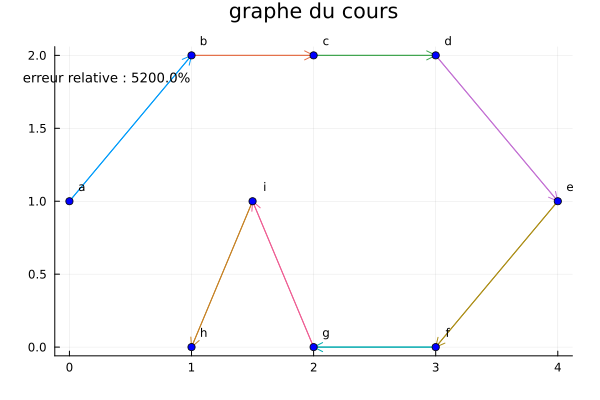

In [50]:
r = HK(cours) # converge en 15 itérations pour le noeud 1
tour_cours = ["a", "b", "c", "d", "e", "f", "g", "i", "h"]
tracer_graphe(tour_cours, cours, offset_x = 0.1, offset_y = 0.1)

In [51]:
poids_tour_cours = sum(map(edge -> edge.weight, r.edges))

61.0

In [55]:
using BenchmarkTools
r = @benchmark HK($cours) # converge en 15 itérations pour le noeud 1

BenchmarkTools.Trial: 6669 samples with 1 evaluation.
 Range (min … max):  573.100 μs …   8.102 ms  ┊ GC (min … max): 0.00% … 85.16%
 Time  (median):     695.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   744.115 μs ± 291.157 μs  ┊ GC (mean ± σ):  2.27% ±  5.27%

             ▃█▃                                                 
  ▁▁▁▂▂▂▂▂▃▃▄███▇▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  573 μs           Histogram: frequency by time          1.1 ms <

 Memory estimate: 179.24 KiB, allocs estimate: 2419.

g. Application aux fichiers `.tsp`

In [38]:
graph_bays29 = build_graph("../Phase 1/instances/stsp/bays29.tsp", "Graph_Test")
r2 = HK(graph_bays29, verbose=1000, maxIter=20000)
poids_tour_bays29 = sum(map(edge -> edge.weight, r2.edges))

┌ Info:  iter         tk     ‖vk‖  weight_graph 
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:53
┌ Info:     0   1.00e+00  5.2e+00  1.6e+03
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  1000   1.00e+00  1.3e+01  -7.7e+05
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92
┌ Info:  2000   1.00e+00  1.3e+01  -3.0e+06
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  3000   1.00e+00  1.3e+01  -6.7e+06
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  4000   1.00e+00  1.3e+01  -1.2e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  5000   1.00e+00  1.3e+01  -1.8e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  6000   1.00e+00  1.3e+01  -2.6e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  7000   1.00e+00  1.3e+01  -3.6e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  8000   1.00e+00  1.3e+01  -4.7e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info:  9000   1.00e+00  1.3e+01  -5.9e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 10000   1.00e+00  1.3e+01  -7.3e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 11000   1.00e+00  1.3e+01  -8.8e+07
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 12000   1.00e+00  1.3e+01  -1.1e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 13000   1.00e+00  1.3e+01  -1.2e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 14000   1.00e+00  1.3e+01  -1.4e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92
┌ Info: 15000   1.00e+00  1.3e+01  -1.6e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 16000   1.00e+00  1.3e+01  -1.9e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 17000   1.00e+00  1.3e+01  -2.1e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


┌ Info: 18000   1.00e+00  1.3e+01  -2.4e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92


maximum iteration criterion reached at k = 20000


┌ Info: 19000   1.00e+00  1.3e+01  -2.6e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:92
┌ Info: 20000   1.00e+00  1.3e+01  -2.9e+08
└ @ Main c:\Users\victo\OneDrive\Documents\Cours\MTH6412B\Projet-Darleguy-Allairev2\Phase 3\Rapport-Phase_3.ipynb:119


3420.0

Le résultat de l'exécution de l'algorithme de Held-Karp sur le graphe graph_bays29 ne semble pas converger vers une solution optimale. En effet, malgré un grand nombre d'itérations (`maxIter=20000`), la norme du vecteur vk reste constante à 1.3e+01, indiquant que l'algorithme ne parvient pas à réduire les écarts par rapport à la contrainte de degré souhaitée pour chaque nœud (qui est de deux pour un cycle hamiltonien).

In [40]:
graph_swiss42 = build_graph("../Phase 1/instances/stsp/swiss42.tsp", "Graph_Test")
r3 = HK(graph_swiss42, verbose=1000, maxIter=20000) # ne converge pas
poids_tour_swiss42 = sum(map(edge -> edge.weight, r3.edges))

2906.0

L'algorithme ne converge pas pour `swiss42.tsp`.

In [41]:
graph_gr17 = build_graph("../Phase 1/instances/stsp/gr17.tsp", "Graph_Test")
r4 = HK(graph_gr17, verbose=1000, maxIter=20000) # ne converge pas
poids_tour_gr17 = sum(map(edge -> edge.weight, r4.edges))

2743.0

L'algorithme ne converge pas pour `gr17.tsp`.